In [1]:
import GLM as gl
import numpy as np
import torch
import matplotlib.pyplot as plt

H data are loaded


<ErrorbarContainer object of 3 artists>

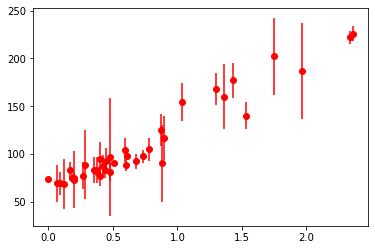

In [2]:
from pathlib import Path
import os
cwd=os.getcwd()

path_lcp = cwd + '/data/hubel.dat'
lcp_file = Path(path_lcp)


if lcp_file.is_file():

    lcp = np.genfromtxt(path_lcp)
                
    z_obs = lcp[:,0]
    H_obs = lcp[:,1]
    dH_obs = lcp[:,2] 

    print("H data are loaded")   
    
else:
    print("H files do not exist")
    sys.exit(0) 



cov_mat_H = np.zeros((len(z_obs),len(z_obs)))
np.fill_diagonal(cov_mat_H,dH_obs**2)
#sig_H = np.sqrt(cov_mat_H.diagonal())

data = np.c_[z_obs,H_obs,dH_obs]

plt.errorbar(z_obs,H_obs,yerr=dH_obs,fmt='o',lw=1,elinewidth=1.5,color="red")

In [93]:
Activation = torch.nn.SiLU()
#Initialize the GLM-Net
# first number is number of hidden layers including last layer
# The list is number of neurons at each layer
# Last number shows number of functions in the GLM
GL = gl.GL_from_NN(3,[5,3,2],Activation)

In [94]:
#Fit to the data
#the last number is the learning rate
GL.fit(data,10000,2e-3)

Epoch = 1000 $\chi^2$ = 106.62
Epoch = 2000 $\chi^2$ = 56.23
Epoch = 3000 $\chi^2$ = 17.78
Epoch = 4000 $\chi^2$ = 17.31
Epoch = 5000 $\chi^2$ = 17.2
Epoch = 6000 $\chi^2$ = 17.15
Epoch = 7000 $\chi^2$ = 17.13
Epoch = 8000 $\chi^2$ = 17.11
Epoch = 9000 $\chi^2$ = 17.09
Epoch = 10000 $\chi^2$ = 17.07
End


In [96]:
#prior information and initializing the Bayesian inference
prior_mean = np.array([0,0])
prior_cov = np.array([[0.02,0],[0,0.02]])
GL.ini_Bayesian(prior_mean,prior_cov)

In [97]:
#max-likelihood estimator of the $\theta_i$ and thier errors
print(GL.max_likelihood_estimator())
print(GL.theta_err())

[ 2.21798297 -1.57251977]
[0.05986671619652162, 0.5660047242227584]


In [98]:
#Bayesian evidence
GL.evidenc()

-149.44863161230114

In [99]:
#prediction
xx = np.linspace(0,3,200)
yy = GL.predict(xx)
yy_err = GL.best_fun_err(xx)

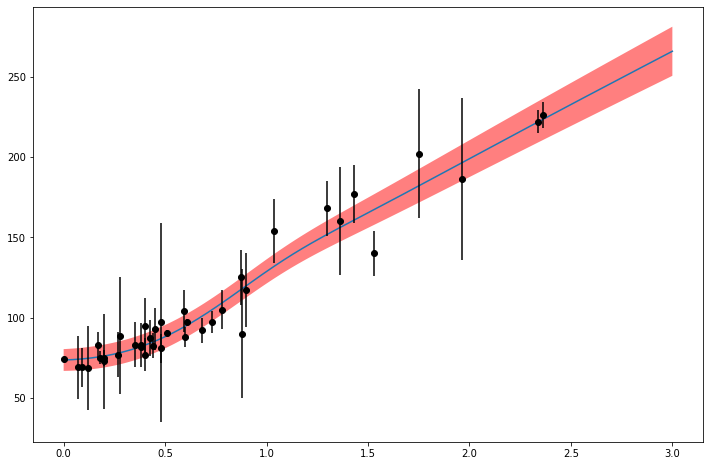

In [100]:
plt.plot(xx,yy)
plt.errorbar(z_obs,H_obs,yerr=data[:,2],fmt='ko')
plt.fill_between(xx,yy - 1.9600 * yy_err,yy + 1.9600 * yy_err,alpha=.5, fc='r', ec='None')

In [59]:
#Parameters inferenc using MCMC
import pymc3 as pm

def Hubble_the(z,H0,omega_m):
    matter=(omega_m)*pow(1.+z,3)
    omega_DE = 1. - omega_m
    DE=omega_DE
    return H0*pow(matter + DE,0.5)


def xi2_h(H0,om):
    H_th = Hubble_the(z_obs,H0,om)
    x = ( H_th - H_obs)/dH_obs 
    return pm.math.dot(x,x)  

def log_likelihood(H0,om):
    return -0.5*( xi2_h(H0,om)  ) 

In [60]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    om = pm.Uniform('Omega_m', lower=0.1, upper=0.4)
    H0 = pm.Uniform('H0', lower=60, upper=80)
    
    like = pm.Potential('like', log_likelihood(H0,om))

    #step = pm.Metropolis()
    #step= None
    step = pm.hmc.HamiltonianMC()
    # Inference!
    trace = pm.sample(15000,tune=1500, cores=2,chains=2,step=step) 

/home/ahmad/anaconda3/envs/Deploy_ML/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [H0, Omega_m]


Sampling 2 chains for 1_500 tune and 15_000 draw iterations (3_000 + 30_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8437990320296274, but should be close to 0.65. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/ahmad/anaconda3/envs/Deploy_ML/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/tmp/ipykernel_26637/3288709710.py:10: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/ahmad/anaconda3/envs/Deploy_ML/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results.

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Omega_m   0.236  0.015   0.209    0.265      0.000    0.000    9547.0   
H0       72.076  1.035  70.141   74.035      0.011    0.007    9556.0   

         ess_tail  r_hat  
Omega_m   14133.0    1.0  
H0        14437.0    1.0  
xi2_best = 30.594819996557746
om_best = 0.23647518082767874
H0_best = 72.07577963346431


array([[<AxesSubplot:title={'center':'Omega_m'}>,
        <AxesSubplot:title={'center':'Omega_m'}>],
       [<AxesSubplot:title={'center':'H0'}>,
        <AxesSubplot:title={'center':'H0'}>]], dtype=object)

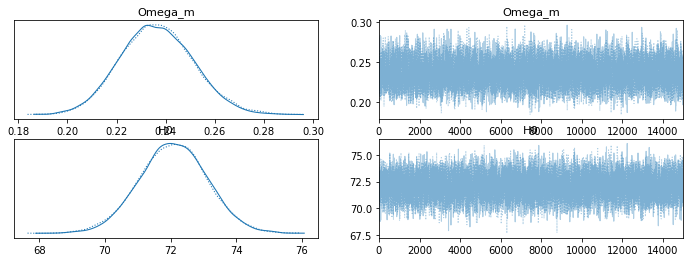

In [61]:
logp = model.logp
lnp = np.array([logp(trace.point(i,chain=c)) for c in trace.chains for i in range(len(trace))])
xi2_best = np.amin(-2*lnp)
om_best = np.mean(trace['Omega_m'])
H0_best = np.mean(trace['H0'])
print(pm.summary(trace))
print("xi2_best =",xi2_best)
print("om_best =",om_best)
print("H0_best =",H0_best)
pm.traceplot(trace)

In [62]:
# Computing uncertainty of the Hubble function in $\Lambda$CDM
z = np.linspace(0,3,200)
Ht = np.zeros((len(z),len(trace['H0'])))
Ht_mean = np.zeros((len(z),))
Ht_err = np.zeros((len(z),))
for i in range(len(z)):
    Ht[i] = Hubble_the(z[i],trace['H0'],trace['Omega_m'])
    Ht_mean[i] = np.mean(Ht[i,:])
    Ht_err[i] = np.std(Ht[i,:])

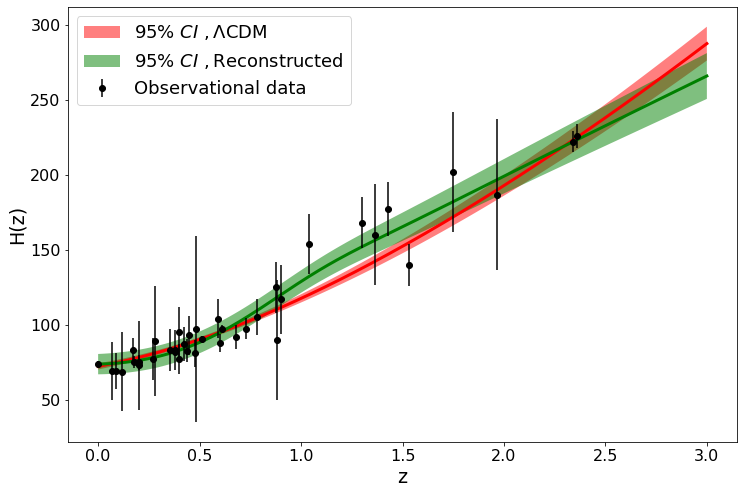

In [102]:
plt.rcParams['figure.figsize'] = (12,8)

Hm = Hubble_the(z,H0_best,om_best)
plt.plot(z,Hm,lw=3,c="r")
plt.plot(xx,yy,lw=3,c="g")
plt.errorbar(z_obs,H_obs,yerr=data[:,2],fmt='ko',label="Observational data")
plt.fill_between(z,Hm - 1.9600 * Ht_err,Hm + 1.9600 * Ht_err,alpha=.5, fc='r', ec='None',label="$95\%~CI~,\Lambda$CDM")
plt.fill_between(xx,yy - 1.9600 * yy_err,yy + 1.9600 * yy_err,alpha=.5, fc='g', ec='None',label="$95\%~CI~,$Reconstructed")
plt.xlabel('z',fontsize=19)
plt.ylabel('H(z)',fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("hub.pdf")